## Predicting Airbnb Listing Price | Analysis

This notebook explores feature creation and machine learning modeling to predict the price variable from other features in the data.

In [64]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import auc, roc_curve, mean_squared_error

In [2]:
SEED = 1
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
sns.set_style("white")
cores = mp.cpu_count()

### Feature Engineering

Most of the data being used for modeling is numeric, but the only string feature, the review text, can be turned into an additional numeric feature using natural language processing techniques. I chose to use VADER sentiment analysis to engineer this feature. According to it's [Github page](https://github.com/cjhutto/vaderSentiment), VADER (Valence Aware Dictionary and sEntiment Reasoner) "is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains". After running a string through the Sentiment Intensity Analyzer from the vaderSentiment package, the analyzer returns numeric scores for the positivity, negativity, and neutrality of a sentence.

Before using VADER, I preprocessed the reviews text to remove some extraneous characters such as "\\", "\[", and "\]". For VADER, stopwords and punctuation should be kept in since the classifier incorporates those elements into the analysis.

To use the Sentiment Intensity Analyzer, I wrote my own function called `get_review_sentiment()` that wraps the analyzer in a try-except loop and only returns the positive aspect of the score. Once all sentiment scores were retrieved from review data, I added them to the dataframe as a new column called `pos_score`. Therefore, the review text gets turned into a numeric feature about the positivity of the reviews that a certain listing receives.

For the initial exploration of the creation of `pos_score` and ease of use, I only used the first 1000 rows of the dataset.

In [3]:
directory = '/Users/limesncoconuts2/datasets/airbnb/'
df = pd.read_csv(directory + 'df_clean.csv', nrows=1000)

In [4]:
df.reviews = df.reviews.str.replace("[","").str.replace("]","") \
                    .str.replace("\\","").str.replace("\"","") \
                    .str.replace("\'","").str.replace("rn","").str.strip()

In [5]:
def get_review_sentiment(review, analyzer):
    """Returns the positive sentiment score of a given string
    using a pre-defined VADER sentiment analysis object.
    If string is null, return 0.
    """
    try:
        score = analyzer.polarity_scores(review)
        score = score['pos']
    
    except: # if nan
        score = 0
    
    return score

In [6]:
%%time
analyzer = SentimentIntensityAnalyzer()

pool = mp.Pool(cores)
results = [pool.apply(get_review_sentiment, args=(row, analyzer)) for row in df.reviews]
pool.close()    

df['pos_score'] = results

CPU times: user 3.45 s, sys: 1.44 s, total: 4.89 s
Wall time: 14min 8s


In [7]:
df_sorted = df[['reviews', 'pos_score']].dropna().sort_values(by=['pos_score'], ascending=False)

#### Examples of most and least positive reviews using vaderSentiment:

In [8]:
most_pos = list(df_sorted.head(5).reviews.values)
print("Most positive reviews:")
print("-----------------------")
print("")
for i in most_pos:
    print(i)
    print("")

Most positive reviews:
-----------------------

Great

Perfect 👌🏼

Marcy was great very sweet!

Amazing spectacular experience , highly recommend

Awesome host. Great communication and accommodation skills. Made sure I was taking care of.



In [9]:
least_pos = df_sorted.tail(10).reviews.values
print("Least positive reviews:")
print("-----------------------")
print("")
for i in least_pos:
    print(i)
    print("")

Least positive reviews:
-----------------------

普段通りの生活ができ、とてもすごしやすかった

房间和照片中的一样，房东想的很周到，并且带我们去了附近的亚洲超市，非常感谢！下次来洛杉矶还会选择住在这里。

The host canceled this reservation 4 days before arrival. This is an automated posting.

Hillary很热情,给予我们很大的帮助。地理位置非常好,靠近好莱坞影视城,房间非常干净、舒适、温馨,房间内的生活用品非常齐全。这是我们来美国住过民宿中的最好的一次。, Hillary很热情，给予我们很大的帮助。地理位置非常好，靠近好莱坞影视城，房间非常干净、舒适、温馨，房间内的生活用品非常齐全。这是我们来美国住过民宿中的最好的一次。, Hillary非常好，房子非常干净，周围很安全，去环球影视城很近。谢谢你

Ya es la segunda vez que elijo esta casa en West Hollywood, la elijo porque es muy linda, tiene todas las comodidades, todo funciona muy bien, tiene muchos cuartos y está en un barrio muy bonito y estratégico para moverse con comodidad en Los Angeles.Nina y Kevin son muy serviciales, están disponibles en todo momento y a cualquier hora para solucionar lo que se necesite y dar consejos para que la estadía sea perfecta.Son tan adorables y confiables que lo hacen sentir a uno como si fueran grandes amigos en esa ciudad. Gracias por todo!, The host canceled this reservatio

### Feature Reduction

#### Is VADER data important? 
The negative aspect to using the vaderSentiment package is the very slow speed. For example, 1000 loops of `get_review_sentiment()` takes over 20 minutes, so all 1.1 million data points would take over 10 days to process. Using a random forest regressor and the small dataset for the initial VADER analysis on 1000 rows of data, I analyzed the feature importances to see is `pos_score` would show up.

In [10]:
# random forests for feature selection
X_sent = df.drop(columns=['price_USD', 'reviews'])
y_sent = df.price_USD

X_train, X_test, y_train, y_test = train_test_split(X_sent, y_sent,
                                                    test_size=0.2,
                                                    random_state=SEED)

rf = RandomForestRegressor(n_estimators=500,
                           max_depth=5,
                           n_jobs=-1,
                           random_state=SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

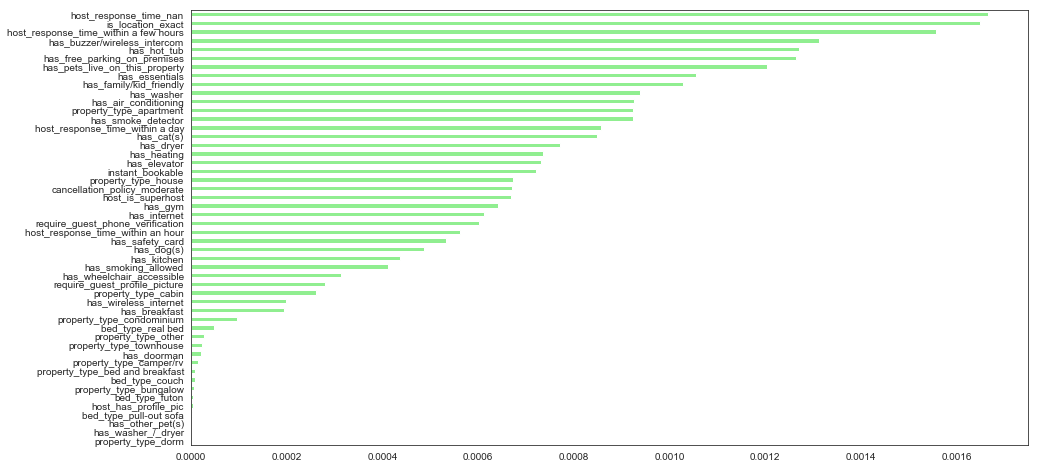

In [11]:
importances_rf = pd.Series(rf.feature_importances_, index = X_sent.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf = sorted_importances_rf[sorted_importances_rf > 0]

fig, ax = plt.subplots(figsize=(15,8))

sorted_importances_rf[:25].plot(kind='barh', color='lightgreen')
plt.show()

In [12]:
'pos_score' in list(sorted_importances_rf[:25].index)

False

Since `pos_score` showed up in the top 25 features, I concluded that it was important to incorporate into the final model of this project. Since the dataset is already large and vaderSentiment analyses are very slow given my hardware constraints, I decided to only work with 50,000 rows of the dataset for the final modeling process.

#### Which Features to Keep?
Even though there will only be one-twentieth of the data in the final modeling process, I still used larger subsets of the data to narrow down the dataset to its most important features. With all features present and with all 1.1 million rows, the dataset was larger than my computer's RAM would allow. Using 500,000 rows of the original clean dataset, I used another random forest regressor to narrow down the 50 most important features that I would then keep for the final modeling process. I kept a list of these column names in a variable called `important_cols`.

In [13]:
df = pd.read_csv(directory + 'df_clean.csv', nrows=500000)

In [14]:
# random forests for feature selection
X_feat = df.drop(columns=['price_USD', 'reviews'])
y_feat = df.price_USD

X_train, X_test, y_train, y_test = train_test_split(X_feat, y_feat, 
                                                    test_size=0.2,random_state=SEED)

rf = RandomForestRegressor(n_estimators=500,
                           max_depth=5,
                           n_jobs=-1,
                           random_state=SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [15]:
y_pred = rf.predict(X_test)

rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
rmse_test

75.36293542584507

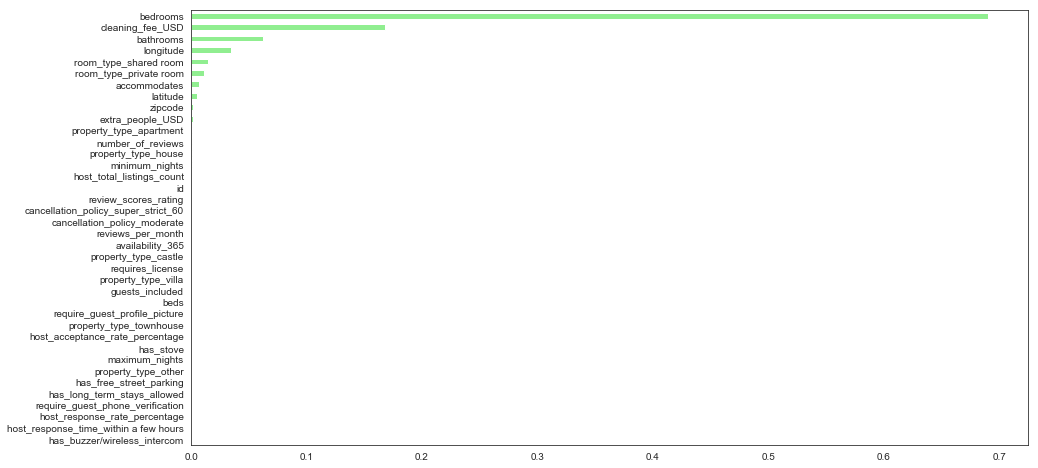

In [16]:
importances_rf = pd.Series(rf.feature_importances_, index = X_feat.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf = sorted_importances_rf[sorted_importances_rf > 0]

fig, ax = plt.subplots(figsize=(15,8))

sorted_importances_rf[:50].plot(kind='barh', color='lightgreen')
plt.show()

In [17]:
important_cols = list(sorted_importances_rf[:50].index) + ['price_USD', 'reviews']

In [18]:
important_cols

['has_buzzer/wireless_intercom',
 'host_response_time_within a few hours',
 'host_response_rate_percentage',
 'require_guest_phone_verification',
 'has_long_term_stays_allowed',
 'has_free_street_parking',
 'property_type_other',
 'maximum_nights',
 'has_stove',
 'host_acceptance_rate_percentage',
 'property_type_townhouse',
 'require_guest_profile_picture',
 'beds',
 'guests_included',
 'property_type_villa',
 'requires_license',
 'property_type_castle',
 'availability_365',
 'reviews_per_month',
 'cancellation_policy_moderate',
 'cancellation_policy_super_strict_60',
 'review_scores_rating',
 'id',
 'host_total_listings_count',
 'minimum_nights',
 'property_type_house',
 'number_of_reviews',
 'property_type_apartment',
 'extra_people_USD',
 'zipcode',
 'latitude',
 'accommodates',
 'room_type_private room',
 'room_type_shared room',
 'longitude',
 'bathrooms',
 'cleaning_fee_USD',
 'bedrooms',
 'price_USD',
 'reviews']

### Modeling
Like previously mentioned, I only used one-twentieth of the dataset and the columns that I previously identified as the most important for creating my model. While not ideal, it allows me to experiment with different methods within the time constraints of this project and the hardware constraints of my computer.

I ran the VADER feature engineering process to create the `pos_score` column for this particular dataset, and then saved the dataframe as a csv file on my computer called `df_ml.csv`. Then I dropped the `reviews` and `price_USD` columns to create my inputs to the model, and identified `price_USD` as the target of my model. After splitting the data into training and testing sets, I trained three different tree-based machine learning models, random forest, stochastic gradient boosting, and XGBoost, and used the root mean squared error to determine which model performed the best. 

Tree-based ensemble models are ideal for this type of analysis, which uses a complex dataset with dozens of features and complex interactions between all of them. Trees allow for the flexibility to fit a model to the specific non-linear trends in the dataset without setting the degree of nonlinearity ahead of time. Ensemble models allow for the combination of several weak tree models to create a model that reduces the variance of the model without compromising too much on bias. Random Forest models are the most simplistic tree-based ensemble model that are built from many aggregated decision trees. The stochastic gradient boosting takes this one step further by improving and building upon iterative models based on their errors, while adding variation from choosing a random subsample of the data at each iteration. The use of subsets of data also makes it harder for the model to overfit to the training data. XGBoost takes gradient boosting even further by implementing second-order gradients of the loss function, which provides more information about minimizing the loss function of the model. It also used advanced regularization which helps the model to generalize better in many cases.

Stochastic gradient boosting worked best in this scenario, with the lowest RMSE score of 43.9.

In [19]:
df = pd.read_csv(directory + 'df_clean.csv',
                 nrows=110000,
                 usecols=important_cols)

In [20]:
df.reviews = df.reviews.str.replace("[","").str.replace("]","") \
                    .str.replace("\\","").str.replace("\"","") \
                    .str.replace("\'","").str.replace("rn","").str.strip()

In [21]:
destination = '/Users/limesncoconuts2/datasets/airbnb/'
filename = 'df_ml.csv'

if(not os.path.isfile(destination + filename)):  
    analyzer = SentimentIntensityAnalyzer()
    pool = mp.Pool(cores)
    results = [pool.apply(get_review_sentiment, args=(row, analyzer)) for row in df.reviews]
    pool.close()
    df['pos_score'] = results

    # save df with pos_score column
    current_dir = os.getcwd() + '/' + filename
    df.to_csv(filename, index=False)
    shutil.move(os.path.join(current_dir), os.path.join(destination, filename))

In [22]:
df = pd.read_csv(directory + 'df_ml.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
accommodates                             50000 non-null float64
availability_365                         50000 non-null float64
bathrooms                                50000 non-null float64
bedrooms                                 50000 non-null float64
beds                                     50000 non-null float64
cleaning_fee_USD                         50000 non-null float64
extra_people_USD                         50000 non-null float64
guests_included                          50000 non-null int64
host_acceptance_rate_percentage          50000 non-null float64
host_response_rate_percentage            50000 non-null float64
host_total_listings_count                50000 non-null float64
id                                       50000 non-null float64
latitude                                 50000 non-null float64
longitude                                50000 non-null float

In [24]:
X = df.drop(columns=['reviews', 'price_USD'])
y = df['price_USD']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

#### Random Forest

In [26]:
rf = RandomForestRegressor(n_estimators=800,
                          max_depth=5,
                          n_jobs=-1,
                          random_state=SEED)

In [28]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [30]:
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
print('Random Forest Root Mean Squared Error:', rmse_test)

Random Forest Root Mean Squared Error: 71.91041927983758


#### Stochastic Gradient Boosting

In [31]:
gb = GradientBoostingRegressor(n_estimators=800,
                                subsample=0.8,
                                max_depth=5,
                                random_state=SEED)

In [33]:
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [34]:
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
print('Stochastic Gradient Boosting Root Mean Squared Error:', rmse_test)

Stochastic Gradient Boosting Root Mean Squared Error: 43.949666173012226


#### XGBoost

In [110]:
xg_reg = xgb.XGBRegressor(n_estimators=800,
                          max_depth=5,
                          objective='reg:linear',
                          n_jobs=cores,
                          random_state=SEED)

In [112]:
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

In [113]:
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
print('XGBoost Root Mean Squared Error:', rmse_test)

XGBoost Root Mean Squared Error: 44.728063554100025


### Model Tuning

I used randomized search cross validation to optimize the best performing model, which was the stochastic gradient boosting model. The randomized search validation chooses the best model based on the R<sup>2</sup> metric, which is a measure of how much variation in the target variable `y` can be explained by the features in `X`.

In [124]:
gb_params = {
    "n_estimators": [500],
    "subsample": [0.7, 1],
    "max_depth": [5, 7, 9],
    "learning_rate": [0.01, 0.1],
    "random_state": [SEED]
}

gb = GradientBoostingRegressor()

In [125]:
gb_grid = GridSearchCV(estimator=gb,
                   param_grid=gb_params,
                   scoring = 'neg_mean_squared_error',
                   cv=5,
                   n_jobs=-1)

In [126]:
gb_grid.fit(X_train, y_train)
gb_best_hyperparams = gb_grid.best_params_
gb_best_model = gb_grid.best_estimator_
gb_best_score = gb_grid.best_score_
print('Best hyperparameters:\n', gb_best_hyperparams)
print('RMSE:', np.sqrt(np.abs(gb_best_score)))

Best hyperparameters:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.7}
RMSE: 46.765959562619514


#### Comparison with a more tuned XGBoost Model

In [165]:
xg_params = {
    "n_estimators": [500],
    "objective": ['reg:linear'],
    "subsample": [0.5, 0.8],
    "max_depth": [5, 7],
    "learning_rate": [0.01],
    "colsample_bytree": [0.9, 1],
    "eval_metrics": ['rmse'],
    "n_jobs": [cores],
    "random_state": [SEED]
}

xg = xgb.XGBRegressor()

In [166]:
xg_grid = GridSearchCV(estimator=xg,
                   param_grid=xg_params,
                   scoring = 'neg_mean_squared_error',
                   cv=5,
                   n_jobs=-1)

In [167]:
xg_grid.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)])
xg_best_hyperparams = xg_grid.best_params_
xg_best_model = xg_grid.best_estimator_
xg_best_score = xg_grid.best_score_
print('Best hyperparameters:\n', xg_best_hyperparams)
print('RMSE:', np.sqrt(np.abs(xg_best_score)))

[0]	validation_0-rmse:192.311	validation_1-rmse:193.247
[1]	validation_0-rmse:190.643	validation_1-rmse:191.592
[2]	validation_0-rmse:188.995	validation_1-rmse:189.938
[3]	validation_0-rmse:187.371	validation_1-rmse:188.328
[4]	validation_0-rmse:185.77	validation_1-rmse:186.729
[5]	validation_0-rmse:184.193	validation_1-rmse:185.155
[6]	validation_0-rmse:182.615	validation_1-rmse:183.594
[7]	validation_0-rmse:181.053	validation_1-rmse:182.034
[8]	validation_0-rmse:179.513	validation_1-rmse:180.494
[9]	validation_0-rmse:178.005	validation_1-rmse:179.018
[10]	validation_0-rmse:176.503	validation_1-rmse:177.525
[11]	validation_0-rmse:175.012	validation_1-rmse:176.037
[12]	validation_0-rmse:173.546	validation_1-rmse:174.599
[13]	validation_0-rmse:172.093	validation_1-rmse:173.156
[14]	validation_0-rmse:170.652	validation_1-rmse:171.714
[15]	validation_0-rmse:169.23	validation_1-rmse:170.308
[16]	validation_0-rmse:167.819	validation_1-rmse:168.908
[17]	validation_0-rmse:166.429	validation_1

[144]	validation_0-rmse:74.1107	validation_1-rmse:76.9839
[145]	validation_0-rmse:73.7968	validation_1-rmse:76.685
[146]	validation_0-rmse:73.4973	validation_1-rmse:76.4026
[147]	validation_0-rmse:73.2068	validation_1-rmse:76.1228
[148]	validation_0-rmse:72.9231	validation_1-rmse:75.8565
[149]	validation_0-rmse:72.6381	validation_1-rmse:75.585
[150]	validation_0-rmse:72.3547	validation_1-rmse:75.309
[151]	validation_0-rmse:72.0807	validation_1-rmse:75.0614
[152]	validation_0-rmse:71.8069	validation_1-rmse:74.8077
[153]	validation_0-rmse:71.5291	validation_1-rmse:74.5483
[154]	validation_0-rmse:71.2597	validation_1-rmse:74.2987
[155]	validation_0-rmse:71.0001	validation_1-rmse:74.0569
[156]	validation_0-rmse:70.7356	validation_1-rmse:73.8068
[157]	validation_0-rmse:70.4664	validation_1-rmse:73.5532
[158]	validation_0-rmse:70.2044	validation_1-rmse:73.3146
[159]	validation_0-rmse:69.9506	validation_1-rmse:73.0709
[160]	validation_0-rmse:69.6989	validation_1-rmse:72.8349
[161]	validation_

[286]	validation_0-rmse:53.4948	validation_1-rmse:58.1196
[287]	validation_0-rmse:53.4321	validation_1-rmse:58.0671
[288]	validation_0-rmse:53.3745	validation_1-rmse:58.0214
[289]	validation_0-rmse:53.316	validation_1-rmse:57.9735
[290]	validation_0-rmse:53.2536	validation_1-rmse:57.9224
[291]	validation_0-rmse:53.1932	validation_1-rmse:57.8743
[292]	validation_0-rmse:53.1231	validation_1-rmse:57.8058
[293]	validation_0-rmse:53.0699	validation_1-rmse:57.7581
[294]	validation_0-rmse:53.0208	validation_1-rmse:57.7131
[295]	validation_0-rmse:52.9696	validation_1-rmse:57.6599
[296]	validation_0-rmse:52.9141	validation_1-rmse:57.6245
[297]	validation_0-rmse:52.8564	validation_1-rmse:57.5752
[298]	validation_0-rmse:52.8031	validation_1-rmse:57.5322
[299]	validation_0-rmse:52.7461	validation_1-rmse:57.4882
[300]	validation_0-rmse:52.6951	validation_1-rmse:57.4522
[301]	validation_0-rmse:52.6443	validation_1-rmse:57.4152
[302]	validation_0-rmse:52.5922	validation_1-rmse:57.3718
[303]	validatio

[428]	validation_0-rmse:47.946	validation_1-rmse:53.7194
[429]	validation_0-rmse:47.9161	validation_1-rmse:53.7001
[430]	validation_0-rmse:47.8832	validation_1-rmse:53.6826
[431]	validation_0-rmse:47.8618	validation_1-rmse:53.6671
[432]	validation_0-rmse:47.8371	validation_1-rmse:53.6529
[433]	validation_0-rmse:47.8059	validation_1-rmse:53.6268
[434]	validation_0-rmse:47.7734	validation_1-rmse:53.6081
[435]	validation_0-rmse:47.7366	validation_1-rmse:53.581
[436]	validation_0-rmse:47.7143	validation_1-rmse:53.5685
[437]	validation_0-rmse:47.6762	validation_1-rmse:53.5417
[438]	validation_0-rmse:47.6539	validation_1-rmse:53.5262
[439]	validation_0-rmse:47.6251	validation_1-rmse:53.5071
[440]	validation_0-rmse:47.5987	validation_1-rmse:53.4942
[441]	validation_0-rmse:47.5768	validation_1-rmse:53.4834
[442]	validation_0-rmse:47.5475	validation_1-rmse:53.4636
[443]	validation_0-rmse:47.5214	validation_1-rmse:53.4486
[444]	validation_0-rmse:47.4911	validation_1-rmse:53.4256
[445]	validation

In [171]:
test = xg_best_model.evals_result()

### RMSE Boxplots

In [178]:
xg_results = pd.DataFrame.from_dict(xg_grid.cv_results_)

In [138]:
gb_results = pd.DataFrame.from_dict(gb_grid.cv_results_)

In [134]:
gb_train = np.sqrt(np.abs(gb_results.mean_train_score))
gb_test = np.sqrt(np.abs(gb_results.mean_test_score))
xg_train = np.sqrt(np.abs(xg_results.mean_train_score))
xg_test = np.sqrt(np.abs(xg_results.mean_test_score))

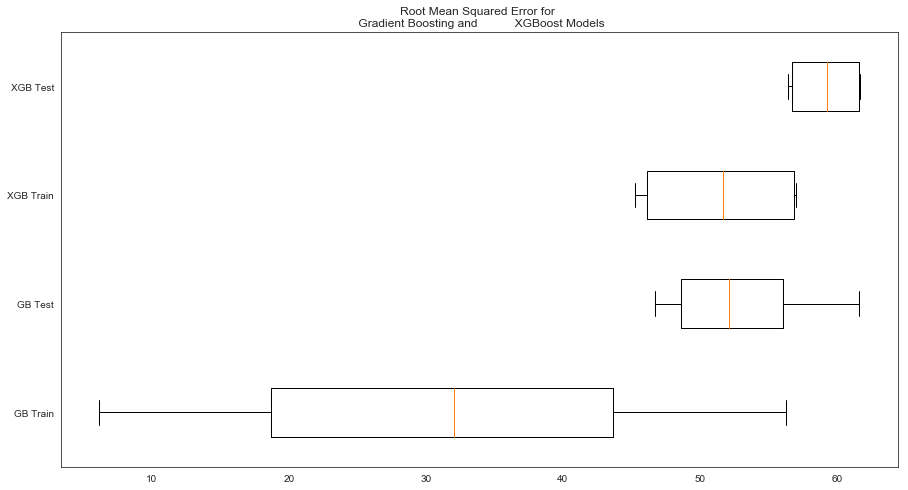

In [135]:
fig, ax = plt.subplots(figsize=(15, 8))
plt_data = [gb_train, gb_test, xg_train, xg_test]
labels = ['GB Train', 'GB Validation', 'XGB Train', 'XGB Validation']
plt.boxplot(plt_data, vert=0)
plt.yticks(np.arange(len(labels))+1, labels)
plt.title("Root Mean Squared Error for \n Gradient Boosting and XGBoost Models")
plt.show()

### Running the Models on the Test Dataset:

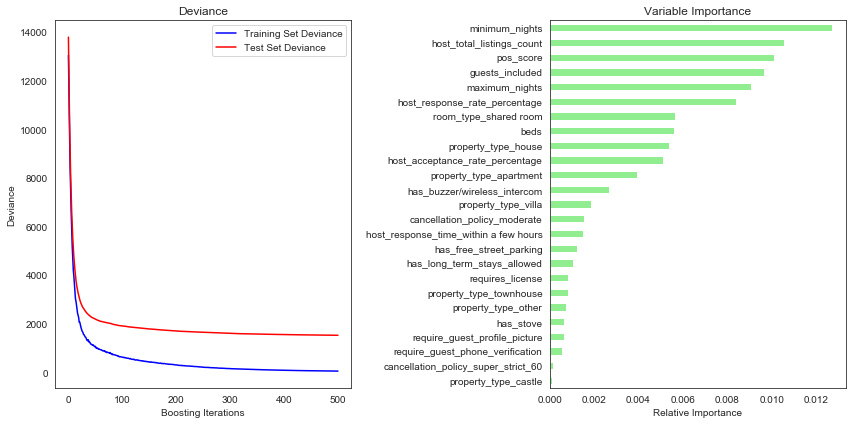

In [127]:
# compute test set deviance
test_score = np.zeros((500,), dtype=np.float64)

for i, y_pred in enumerate(gb_best_model.staged_predict(X_test)):
    test_score[i] = gb_best_model.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(500) + 1, gb_best_model.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# feature importances
importances = pd.Series(gb_best_model.feature_importances_, index = X.columns)
sorted_importances = importances.sort_values()
sorted_importances = sorted_importances[sorted_importances > 0]

plt.subplot(1, 2, 2)
sorted_importances[:25].plot(kind='barh', color='lightgreen')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.show()

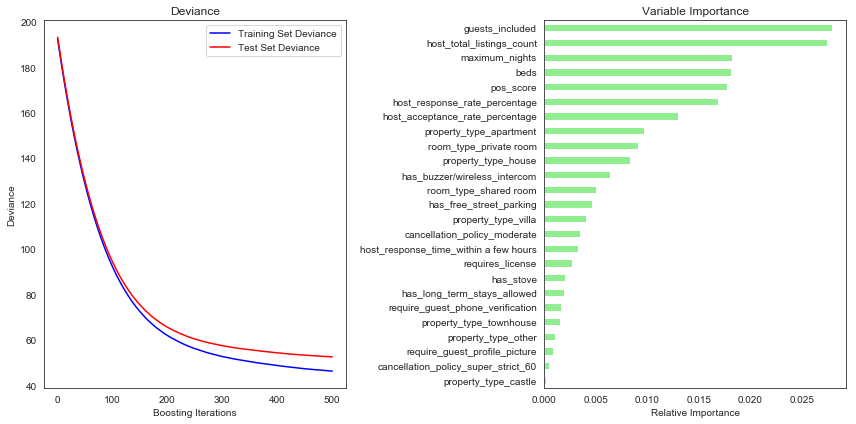

In [182]:
# XGBOOST
train_score = np.zeros((500,), dtype=np.float64)
test_score = np.zeros((500,), dtype=np.float64)

xg_evals = xg_best_model.evals_result()
scores = []

for i in xg_evals.keys():
    scores.append(xg_evals[i]['rmse'])
train_scores = scores[0]
test_scores = scores[1]

### using test data
test_score = xg_evals[i]['rmse']
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(500) + 1, train_scores, 'b-', label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_scores, 'r-', label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# feature importances
importances_xg = pd.Series(xg_best_model.feature_importances_, index = X.columns)
sorted_importances_xg = importances_xg.sort_values()
sorted_importances_xg = sorted_importances_xg[sorted_importances_xg > 0]

plt.subplot(1, 2, 2)
sorted_importances_xg[:25].plot(kind='barh', color='lightgreen')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.show()

### Conclusions

info here

#### Future Improvements

In order for the model to work best for the client, the most obvious next step would be to make it production ready. If given more time, I would implement a pipeline in which the data could be read directly into the program, automatically cleaned and processed for feature creation, and run through the machine learning model. This would allow for the client to use my model without having to go through all of the laborious steps themselves.

Looking more inside the model, for the VADER sentiment analysis I would do more preprocessing of the review data to remove non-English reviews to have a cleaner analysis that doesn't numerically de-value non-English entries. I would also like to include more string features into the dataset using VADER, like the listing description or rules data. Additionally, it would also be interesting to see what other NLP methods could be applied to the text data using a package like word2vec or doc2vec.

To make this analysis stronger, I would train these models on the entire Los Angeles dataset, and then to other cities represented in the entire Inside Airbnb dataset. The infrastructure for scaling this model has already been incorporated through the use of functions, but further generalization using object-oriented programming principles could make for an even stronger model. I would also spend more time tuning the model using Randomized Search or the more thorough Grid Search method.